In [1]:
import functions as fn
import numpy as np
import matplotlib.pyplot as plt

In [42]:
Sim_period = 100  # seconds
Sim_fs = 10000  # samples per second

Sim_dt = 1/Sim_fs
Sim_t = np.arange(0, Sim_period, Sim_dt)

In [48]:
C = .00001  # F

R_leak = 1e5
V_leak = 0

L = 25  # H
R_L = 200  # Ohm
g_L = 1/R_L  # S

I_stim = 1e-6

tau_L = L / R_L

print('Inductor time constant:', tau_L, 's')
print('Resonance frequency:', 1/(2*np.pi*np.sqrt(L*C)), 'Hz')

Inductor time constant: 0.125 s
Resonance frequency: 10.065842420897408 Hz


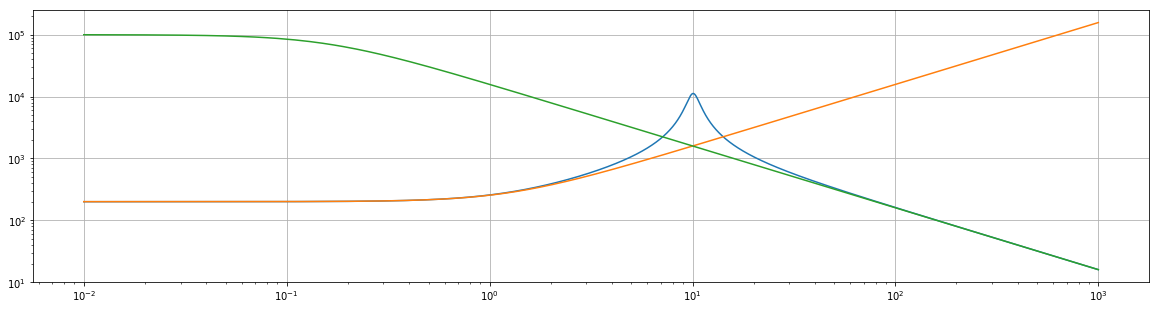

In [49]:
f = np.arange(0.01,1000,.01)  # Hz
w = 2 * np.pi * f

z = (1j*w*C + 1/R_leak + 1/(1j*w*L + R_L)) ** -1
z_amp = np.sqrt(z.real**2 + z.imag**2)

z_L = 1j*w*L + R_L
z_L_amp = np.sqrt(z_L.real**2 + z_L.imag**2)

z_C = (1j * w * C  + 1/R_leak) ** -1
z_C_amp = np.sqrt(z_C.real**2 + z_C.imag**2)

plt.figure(figsize=(20,5))
plt.loglog(f, z_amp)
plt.loglog(f, z_L_amp)
plt.loglog(f, z_C_amp)
plt.grid()
plt.show()

As you can see in the above circuit, I did not put the leak resistance. So let's start simple. Later we'll discuss the importance of leak resistance (for integration of high frequency signal).

Below, i will add a resistor in parallel (same as the leak resistance), but i will change the resistance (or its reciprocal - the inductance) and see the effect on the resonance frequency and damping of the Q factor.

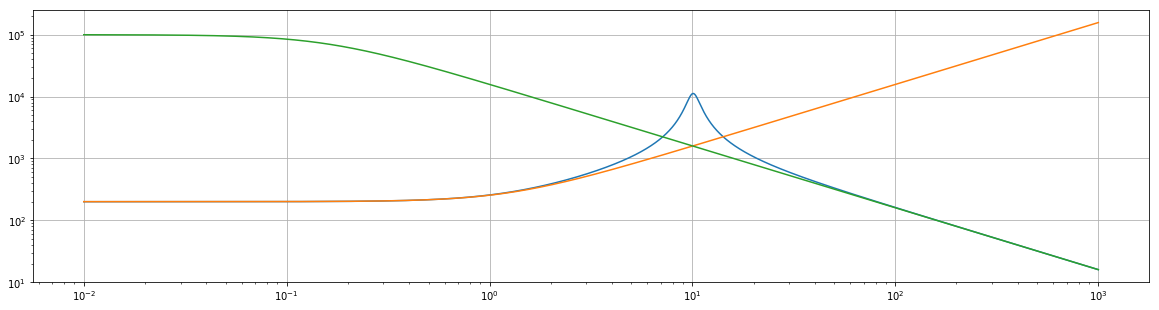

In [50]:
f = np.arange(0.01,1000,.001)  # Hz
w = 2 * np.pi * f

R_p = 200  # Ohm
g_leak = (1 / R_leak) * 1  # increase this value and see the difference

z = (1j*w*C + g_leak + 1/(1j*w*L + R_L)) ** -1
z_amp = np.sqrt(z.real**2 + z.imag**2)

z_L = 1j*w*L + R_L
z_L_amp = np.sqrt(z_L.real**2 + z_L.imag**2)

z_C = (1j * w * C + g_leak) ** -1
z_C_amp = np.sqrt(z_C.real**2 + z_C.imag**2)

plt.figure(figsize=(20,5))
plt.loglog(f, z_amp)
plt.loglog(f, z_L_amp)
plt.loglog(f, z_C_amp)
plt.grid()
plt.show()

As you can see, when the inductance value is high (parallel resistance is low) then that resistance starts to become the dominant branch, which defines the amplification of current at resonance.

Let's simulate the circuit without this resiatance and see the response to a chirp signal. First, we define out stimulation current.

In [ ]:
I = I_stim * np.ones(Sim_t.shape)  # pA
# Sim_t = Sim_t[:Sim_fs*1]
# slope
slope = fn.gen_slope(init_time=0,
                   end_time= 5,
                   time_points=Sim_t)


I1 = fn.gen_sin(init_time=0,
                freq=1000,
                phase=0,
                time_points=Sim_t)
I2 = fn.gen_sin(init_time=0,
                freq=1010,
                phase=0,
                time_points=Sim_t)
I3, freq = fn.gen_chirp(Chirp_init_freq=1000, 
                         Chirp_init_time=0, 
                         Chirp_end_freq=1020, 
                         Chirp_end_time=Sim_t[-1], 
                         time_points=Sim_t)

I = slope * I_stim * (I1 + I2)

# I3 = fn.gen_pulse(init_time=1,
#                   on_width=47,
#                   off_width=1,
#                   time_points=Sim_t)

# # Chirp stimulation
out, freq = fn.gen_chirp(Chirp_init_freq=0.1, 
                         Chirp_init_time=0, 
                         Chirp_end_freq=20, 
                         Chirp_end_time=Sim_t[-1], 
                         time_points=Sim_t)

I      = slope * I_stim * out # pA

## Run first circuit simulation

In [ ]:
Vm = np.zeros(Sim_t.shape)
I_L = np.zeros(Sim_t.shape)
nl = np.zeros(Vm.shape)

In [ ]:
for i in range(I.shape[0]-1):
    
    # current through the inductor
    I_L_ss = Vm[i] * g_L
    dILdt = (I_L_ss - I_L[i]) / tau_L
    I_L[i+1] = I_L[i] + dILdt * Sim_dt
    
    # current through leak branch
    I_leak = (1/R_leak) * (Vm[i] - V_leak)
    
    dVmdt = (I[i] - I_L[i] - I_leak) / C
    Vm[i+1] = Vm[i] + dVmdt * Sim_dt

In [ ]:
plt.figure(figsize=(20,2))
plt.plot(freq, I)
plt.show()

plt.figure(figsize=(20,5))
plt.plot(freq, Vm)
plt.show()

plt.figure(figsize=(20,2))
plt.plot(freq, I_L)
plt.show()

Obviosly, we get a nice resonance

Let's continue by adding the parallel nonlinear resistance.

First, let's define the non-linearity function

In [ ]:
C = .00001  # F

R_leak = 1e5
g_leak = 1 / R_leak
V_leak = 0

L = 25  # H
R_L = 200  # Ohm
g_L = 1/R_L  # S

R_p = 200
g_p = 1/R_p
V_p = 0

I_stim = 2e-6

tau_L = L / R_L

print('Inductor time constant:', tau_L, 's')
print('Resonance frequency:', 1/(2*np.pi*np.sqrt(L*C)), 'Hz')

In [ ]:
f = np.arange(0.01,1000,.001)  # Hz
w = 2 * np.pi * f

R_p = 200  # Ohm
g_p = (1 / R_p) * 1  # increase this value and see the difference

z = (1j*w*C + g_leak + g_p + 1/(1j*w*L + R_L)) ** -1
z_amp = np.sqrt(z.real**2 + z.imag**2)

z_L = 1j*w*L + R_L
z_L_amp = np.sqrt(z_L.real**2 + z_L.imag**2)

z_C = (1j * w * C + g_leak + g_p) ** -1
z_C_amp = np.sqrt(z_C.real**2 + z_C.imag**2)

plt.figure(figsize=(20,5))
plt.loglog(f, z_amp)
plt.loglog(f, z_L_amp)
plt.loglog(f, z_C_amp)
plt.grid()
plt.show()

In [244]:
I = I_stim * np.ones(Sim_t.shape)  # pA
# Sim_t = Sim_t[:Sim_fs*1]
# slope
slope = fn.gen_slope(init_time=0,
                   end_time= 5,
                   time_points=Sim_t)


I1 = fn.gen_sin(init_time=0,
                freq=1000,
                phase=0,
                time_points=Sim_t)
I2 = fn.gen_sin(init_time=0,
                freq=1010,
                phase=0,
                time_points=Sim_t)
I3, freq = fn.gen_chirp(Chirp_init_freq=1000, 
                         Chirp_init_time=0, 
                         Chirp_end_freq=1020, 
                         Chirp_end_time=Sim_t[-1], 
                         time_points=Sim_t)

I = slope * I_stim * (I1 + I2)

# I3 = fn.gen_pulse(init_time=1,
#                   on_width=47,
#                   off_width=1,
#                   time_points=Sim_t)

# # Chirp stimulation
out, freq = fn.gen_chirp(Chirp_init_freq=0, 
                         Chirp_init_time=0, 
                         Chirp_end_freq=20, 
                         Chirp_end_time=Sim_t[-1], 
                         time_points=Sim_t)

I      = slope * I_stim * out # pA

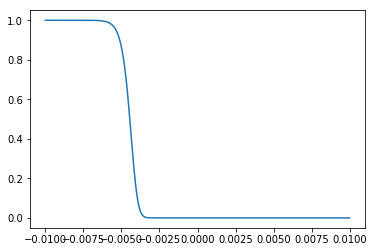

In [245]:
k = 1
V_half = -.004
coeff = 3000  # 5000
Vm = np.arange(-.01, .01, .00001)

Boltzman_nl = 1 - k / (1 + np.exp(coeff*(V_half - Vm)))
plt.plot(Vm, Boltzman_nl**3)
plt.show()

In [246]:
Vm = np.zeros(Sim_t.shape)
I_L = np.zeros(Sim_t.shape)
nl = np.zeros(Vm.shape)

In [247]:
for i in range(I.shape[0]-1):
    
    #non-linearity of parallel conductance
    nl[i] =  1 - k / (1 + np.exp(coeff*(V_half - Vm[i])))
    nl[i] = nl[i]**1

    # current through the parallel branch
    I_p = g_p * nl[i] * (Vm[i] - V_p)
    
    # current through the inductor
    I_L_ss = Vm[i] * g_L
    dILdt = (I_L_ss - I_L[i]) / tau_L
    I_L[i+1] = I_L[i] + dILdt * Sim_dt
    
    # current through leak branch
    I_leak = g_leak * (Vm[i] - V_leak)
    
    dVmdt = (I[i] - I_p - I_L[i] - I_leak) / C
    Vm[i+1] = Vm[i] + dVmdt * Sim_dt

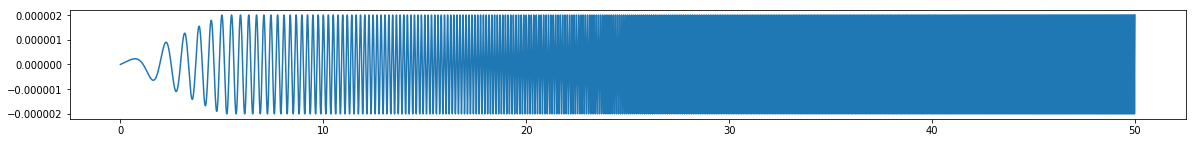

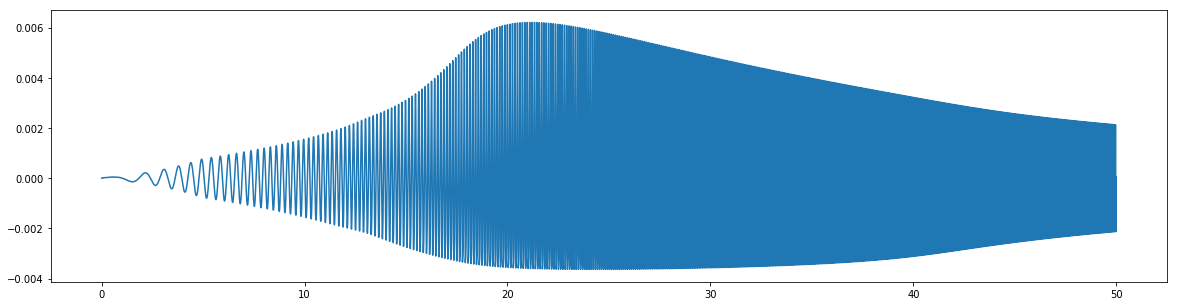

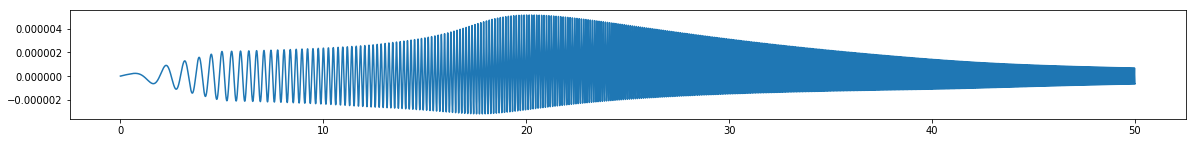

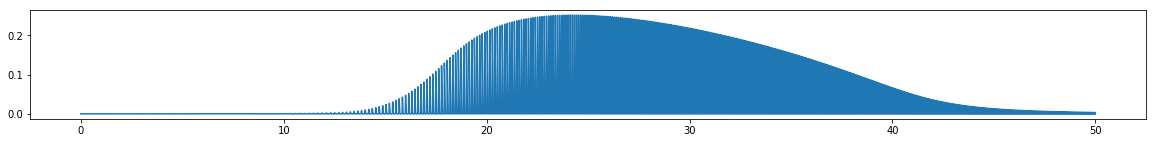

In [248]:
plt.figure(figsize=(20,2))
plt.plot(Sim_t, I)
plt.show()

plt.figure(figsize=(20,5))
plt.plot(Sim_t, Vm)
plt.show()

plt.figure(figsize=(20,2))
plt.plot(Sim_t, I_L)
plt.show()

plt.figure(figsize=(20,2))
plt.plot(Sim_t, nl)
plt.show()

Some points:

1. We see the resonance response 
2. 

## Adding the Na channel without nonlinearity

In [43]:
C = .00001  # F

R_leak = 1e5
g_leak = 1 / R_leak
V_leak = 0

L = 25  # H
R_L = 200  # Ohm
g_L = 1/R_L  # S

R_p = 200
g_p = 1/R_p
V_p = 0

R_Na = 1000
g_Na = 1/R_Na

V_Na = .01

I_stim = 2e-6

tau_L = L / R_L

I_stim = 2e-6

tau_L = L / R_L

print('Inductor time constant:', tau_L, 's')
print('Resonance frequency:', 1/(2*np.pi*np.sqrt(L*C)), 'Hz')

Inductor time constant: 0.125 s
Resonance frequency: 10.065842420897408 Hz


In [64]:
I = I_stim * np.ones(Sim_t.shape)  # pA
# Sim_t = Sim_t[:Sim_fs*1]
# slope
slope = fn.gen_slope(init_time=0,
                   end_time= .5,
                   time_points=Sim_t)


I1 = fn.gen_sin(init_time=0,
                freq=1000,
                phase=0,
                time_points=Sim_t)
I2 = fn.gen_sin(init_time=0,
                freq=1010,
                phase=0,
                time_points=Sim_t)
I3, freq = fn.gen_chirp(Chirp_init_freq=1000, 
                         Chirp_init_time=0, 
                         Chirp_end_freq=1020, 
                         Chirp_end_time=Sim_t[-1], 
                         time_points=Sim_t)

# I = slope * (I_stim * (I1 + I2)) * 57  # 50, 55
I = slope * (I_stim * (I1 + I3)) * 57  # 50, 55

# I3 = fn.gen_pulse(init_time=1,
#                   on_width=47,
#                   off_width=1,
#                   time_points=Sim_t)

# # Chirp stimulation
out, freq = fn.gen_chirp(Chirp_init_freq=0.1, 
                         Chirp_init_time=0, 
                         Chirp_end_freq=20, 
                         Chirp_end_time=Sim_t[-1], 
                         time_points=Sim_t)

# I      = slope * I_stim * out # pA

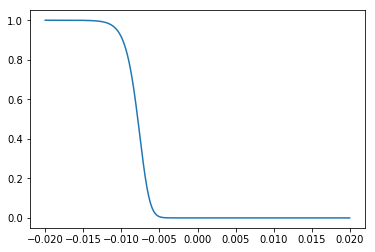

In [65]:
k = 1
V_half = -.0065  # -0.004  -.0045
coeff = 1000  # 3000  1000
Vm = np.arange(-.02, .02, .00001)

Boltzman_nl = 1 - k / (1 + np.exp(coeff*(V_half - Vm)))
plt.plot(Vm, Boltzman_nl**3)
plt.show()

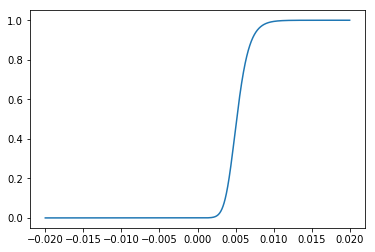

In [66]:
k_Na = 1
V_half_Na = 0.0038  # 0.0035
coeff_Na = 1000      # 500
Vm = np.arange(-.02, .02, .00001)

Boltzman_nl = k_Na / (1 + np.exp(coeff_Na*(V_half_Na - Vm)))
plt.plot(Vm, Boltzman_nl**3)
plt.show()

In [67]:
Vm = np.zeros(Sim_t.shape)
I_L = np.zeros(Sim_t.shape)
I_Na = np.zeros(Sim_t.shape)
nl = np.zeros(Vm.shape)
nl_Na = np.zeros(Vm.shape)

In [68]:
for i in range(I.shape[0]-1):
    
    #non-linearity - resistor branch
    nl[i] =  1 - k / (1 + np.exp(coeff*(V_half - Vm[i])))
    nl[i] = nl[i]**3
    
    # non-linearity - Na branch
    nl_Na[i] =  k_Na / (1 + np.exp(coeff_Na*(V_half_Na - Vm[i])))
    nl_Na[i] = nl_Na[i]**3

    # current through the parallel branch
    I_p = g_p * nl[i] * (Vm[i] - V_p)
    
    # current through the Na
    I_Na[i] = g_Na * nl_Na[i] * (Vm[i] - V_Na)
    
    # current through the inductor
    I_L_ss = Vm[i] * g_L
    dILdt = (I_L_ss - I_L[i]) / tau_L
    I_L[i+1] = I_L[i] + dILdt * Sim_dt
    
    # current through the leak branch
    I_leak = g_leak * (Vm[i] - V_leak)
    
    # remove the nonlinearities (the model becomes linear!)
#     I_p = 0  # if this is set to zero, change V_Na to 0.008
#     I_Na[i] = 0
    
    dVmdt = (I[i] - I_p - I_Na[i] - I_L[i] - I_leak) / C
    Vm[i+1] = Vm[i] + dVmdt * Sim_dt

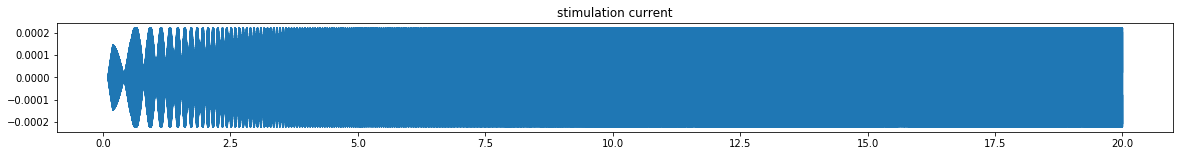

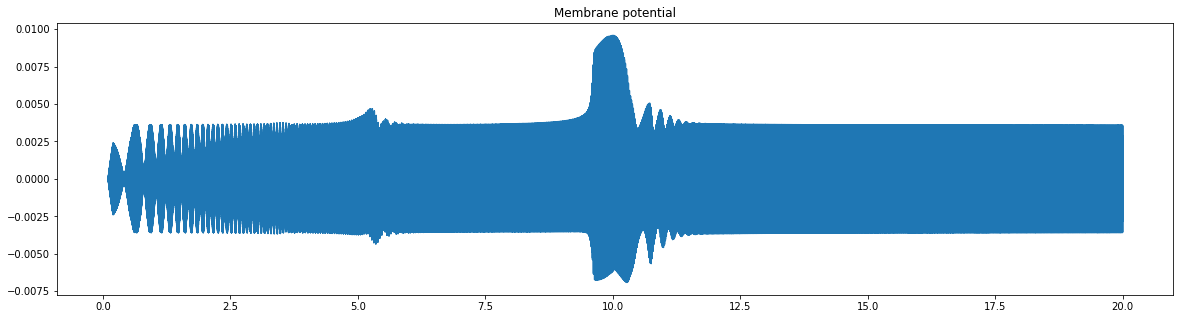

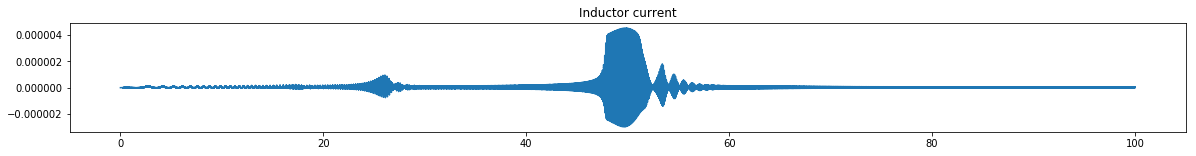

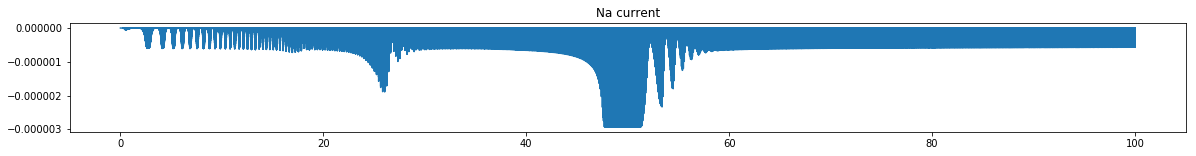

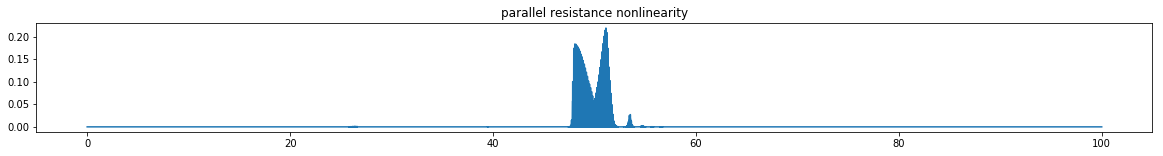

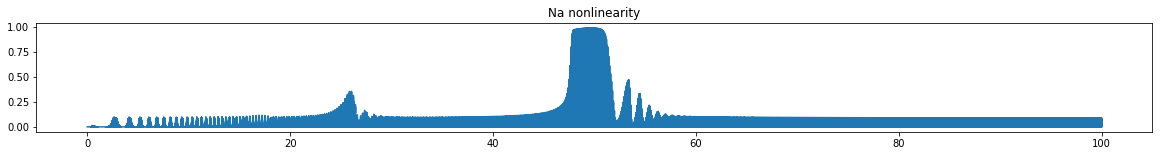

In [69]:
plt.figure(figsize=(20,2))
plt.plot(freq, I)
plt.title('stimulation current')
plt.show()

plt.figure(figsize=(20,5))
plt.plot(freq, Vm)
plt.title('Membrane potential')
plt.show()

plt.figure(figsize=(20,2))
plt.plot(Sim_t, I_L)
plt.title('Inductor current')
plt.show()

plt.figure(figsize=(20,2))
plt.plot(Sim_t, I_Na)
plt.title('Na current')
plt.show()

plt.figure(figsize=(20,2))
plt.plot(Sim_t, nl)
plt.title('parallel resistance nonlinearity')
plt.show()

plt.figure(figsize=(20,2))
plt.plot(Sim_t, nl_Na)
plt.title('Na nonlinearity')
plt.show()

I do not see the integration, nor the nonlinearity with the Na channel added. Possible solutions:

1. adding the constant R_leak to reduce the impedance.
2. R_Na also must be adjusted accordingly

it has to integrate slowly..

**date: 08/03/2018** <br/>
So i have checked shifting up the current (and that is basically what the Na is doing except that Na is dependent on the membrane potential).

**data: 14/03/2018** <br/>
it is starting to show something.. Things that influence:
- nonlinearities: shifting the parallel resistance nonlinearity to the back has a lot of influence!
- Na reverse potential and Na resistance
- We can also remove R_p, but R_p is what makes the response asymetric (below resting potential the response is smaller than above). We can remove this resistance but then it becomes symmetirc.
- Na nonlinearity is what makes the neuron more responsive to a specific modulation frequency. R_p nonlinearity is what makes the neuron suppress high response beloew the resting potential (basically making the membrane impedance depend on membrane potential).

In [459]:
Vm.mean()

1.2151745882847873e-05

At 1 kHz -> -0.006 ~ 0.006 